In this document, I'll try to decide on the clustering method to apply to the data.

## Import libraries and dataset

In [17]:
#Import Libraries
import numpy as np
import pandas as pd

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition

import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [3]:
#Import dataset
DE = pd.read_csv('cleaned_delay_events.csv')

In [4]:
def get_sample(dataset, frac=0.1):
    """Chooses a fraction of dataset randomly and performs the steps necessary to get to applying clustering."""
    if frac < 1.0: df = DE.sample(frac=frac)
    else: df = DE
    
    X_s = preprocessing.scale(df)
    
    # Dimensionality Reduction:
    pca = decomposition.PCA(n_components=.85, svd_solver='full')
    model = pca.fit(X_s)
    
    return (model.transform(X_s), df, X_s, model)

# K-means 

I would like to choose the number of clusters using silhouette score. However, the comutation for the entire dataset is very heavy. So I did this calculation for 10% of data a few times, and the results were consistent each time. They all suggested that best silhouette score for $k > 3$ is around $0.15$ and for larger $k$'s it is around $0.09$. So, the score is typically low, and not very differentiating. Another recurrent theme is that for $k > 10$ the score tends to drop, definitely so for $k > 15$. Below, the plot for one of these calculations is displayed:

### Finding the range of best "k"s on a sample of data  

In [10]:
sample = get_sample(DE, 0.02)
X_r, cmp, *rest = sample

In [12]:
score = []
for k in range(2, 41):
    kmeans = KMeans(n_clusters=k)
    y_pred = kmeans.fit_predict(X_r)
    s = silhouette_score(X_r, y_pred)
    score.append(s)

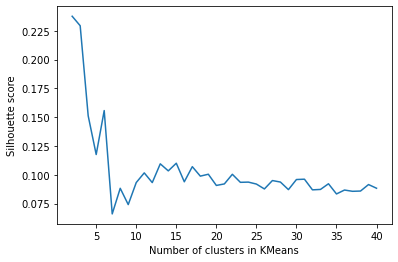

In [13]:
plt.plot(np.arange(2, 41), score)
plt.xlabel('Number of clusters in KMeans')
plt.ylabel('Silhouette score')
plt.show()

The score for smaller number of clusters is better. So, let's have a closer look at these numbers:

## On all data

In [15]:
# Note: We are asking for decomposition.PCA(n_components=.85, svd_solver='full') in code
sample = get_sample(DE, 1)
X = sample[0]

Now that I am working on all data, I will limit the silhouette score calculation to be done on 0.1 of data.

### Inertia, Silhouette score, Davies-Bouldin index, CH score for K-means

From sklearn documentation:
* A  lower Davies-Bouldin index relates to a model with better separation between the clusters. This index signifies the average ‘similarity’ between clusters, where the similarity is a measure that compares the distance between clusters with the size of the clusters themselves.

* The CH score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.

In [18]:
sample_size = 50000 #sample size for silhouette score
kmeans_inertia, kmeans_ch_score, kmeans_db_score, kmeans_s_score = [], [], [],[]
for k in range(2, 28):
    
    kmeans = KMeans(n_clusters=k)
    y_pred = kmeans.fit_predict(X)
    
    kmeans_inertia.append((k,-kmeans.score(X)))

    db = davies_bouldin_score(X, y_pred)
    ch = metrics.calinski_harabasz_score(X, y_pred)
    s = silhouette_score(X, y_pred, sample_size=sample_size)
    kmeans_ch_score.append((k,ch))
    kmeans_db_score.append((k, db))
    kmeans_s_score.append((k, s))

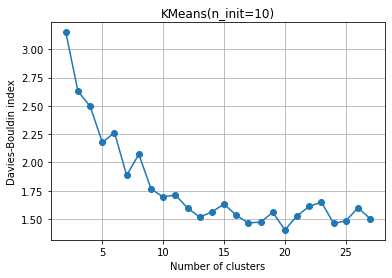

In [19]:
plt.plot([x[0] for x in kmeans_db_score], [x[1] for x in kmeans_db_score] , marker = 'o')
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin index')
plt.title('KMeans(n_init=10)')
plt.grid()
plt.savefig('DB-index-KMeans.png', dpi=150)
plt.show()

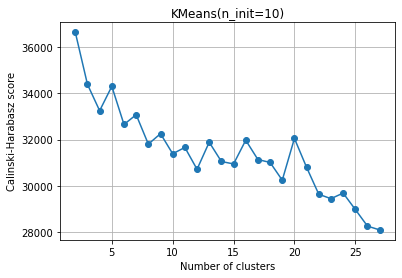

In [20]:
plt.plot([x[0] for x in kmeans_ch_score], [x[1] for x in kmeans_ch_score] , marker = 'o')
plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabasz score')
plt.title('KMeans(n_init=10)')
plt.grid()
plt.savefig('CH-score-KMeans.png', dpi=150)
plt.show()

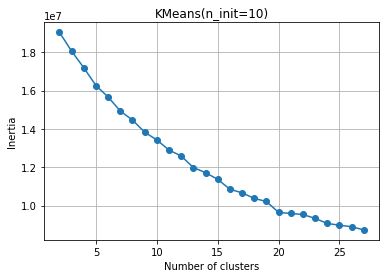

In [21]:
plt.plot([x[0] for x in kmeans_inertia], [x[1] for x in kmeans_inertia], marker ='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('KMeans(n_init=10)')
plt.grid()
plt.savefig('Inertia-KMeans.png', dpi=150)
plt.show()

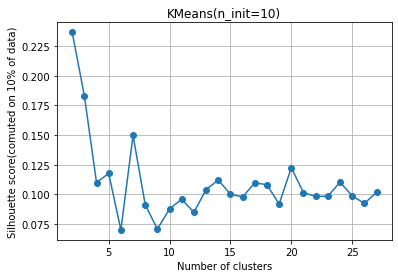

In [22]:
plt.plot([x[0] for x in kmeans_s_score], [x[1] for x in kmeans_s_score] , marker = 'o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score(comuted on 10% of data)')
plt.title('KMeans(n_init=10)')
plt.grid()
plt.savefig('silh-index-KMeans.png', dpi=150)
plt.show()

Looking at the figures, we get an idea of what a 'differentiating' threshold for each score is.

In [23]:
better_ch_score = [x[0] for x in kmeans_ch_score if x[1] > 31500]
better_s_score = [x[0] for x in kmeans_s_score if x[1] >= 0.09]
lower_db_index = [x[0] for x in kmeans_db_score if x[1] < 2.3]
kmeans_chosen = [x for x in better_ch_score if x in lower_db_index]
kmeans_chosen

[5, 6, 7, 8, 9, 11, 13, 16, 20]

For n_clusters = 2 The average silhouette_score is : 0.23787184224668242
For n_clusters = 3 The average silhouette_score is : 0.23083409952391082
For n_clusters = 4 The average silhouette_score is : 0.11358051963354808
For n_clusters = 5 The average silhouette_score is : 0.1169612051078681
For n_clusters = 6 The average silhouette_score is : 0.13746850959032855
For n_clusters = 7 The average silhouette_score is : 0.08179614799105286
For n_clusters = 8 The average silhouette_score is : 0.1501555249083028
For n_clusters = 9 The average silhouette_score is : 0.09170607623485517
For n_clusters = 11 The average silhouette_score is : 0.10141095984909941
For n_clusters = 13 The average silhouette_score is : 0.10827921255935849
For n_clusters = 16 The average silhouette_score is : 0.09570031422673794
For n_clusters = 20 The average silhouette_score is : 0.09610514502190441


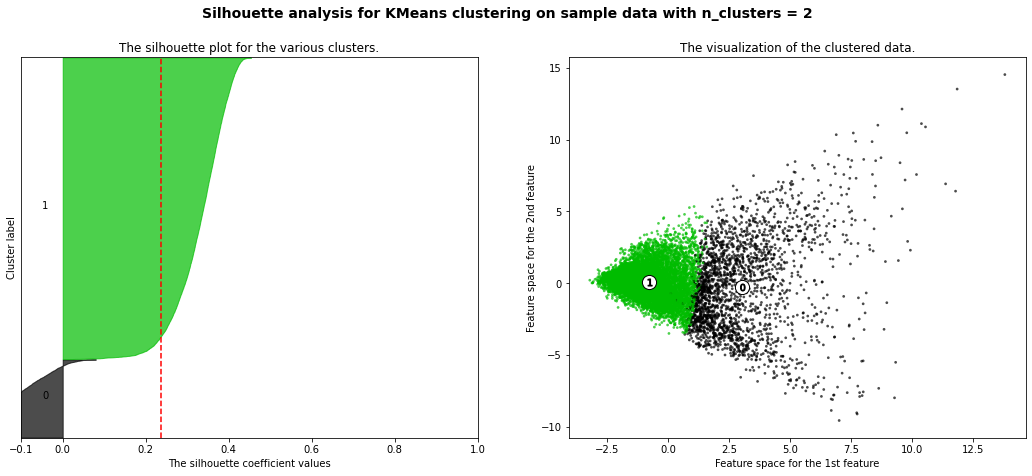

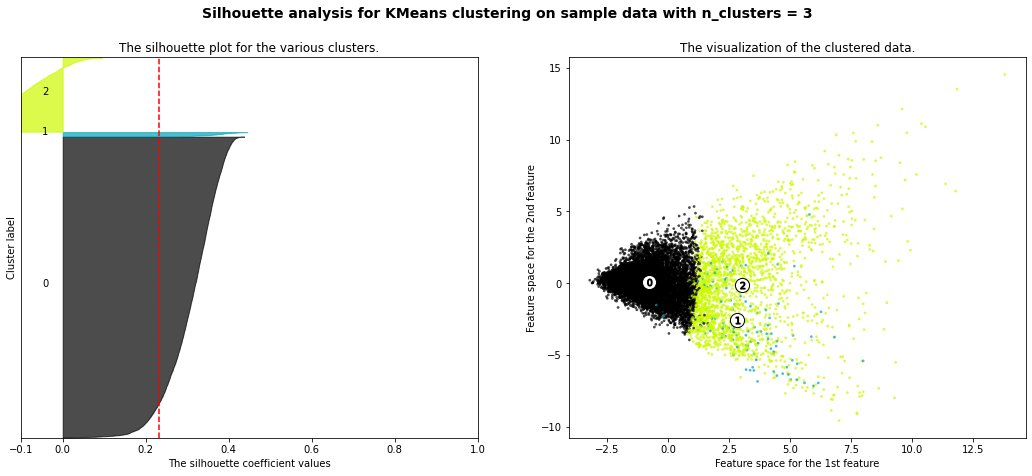

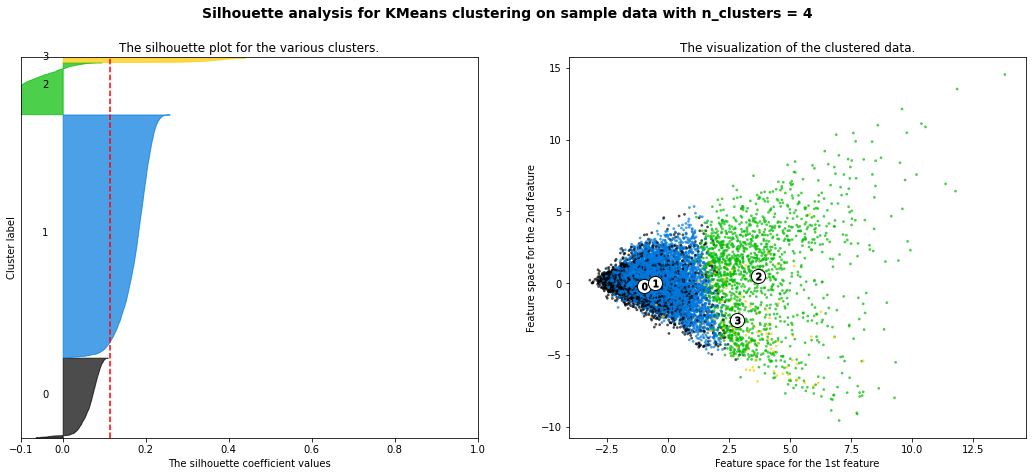

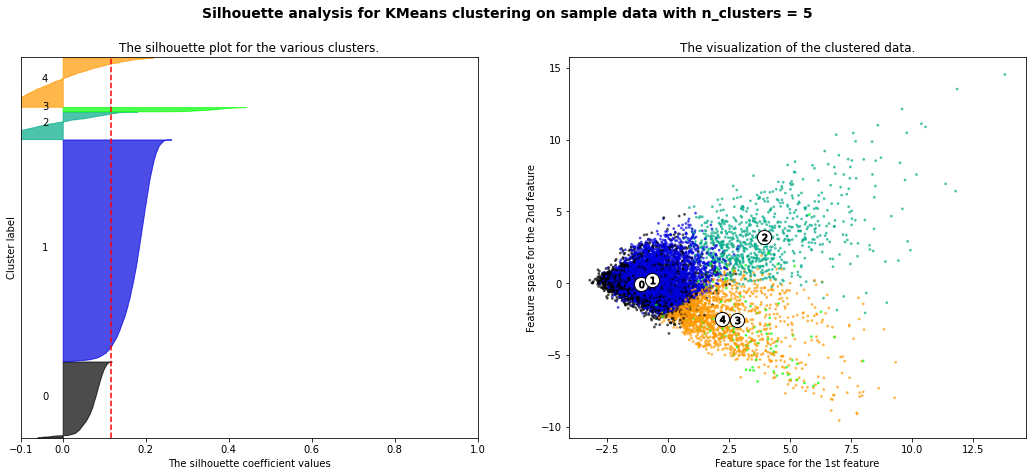

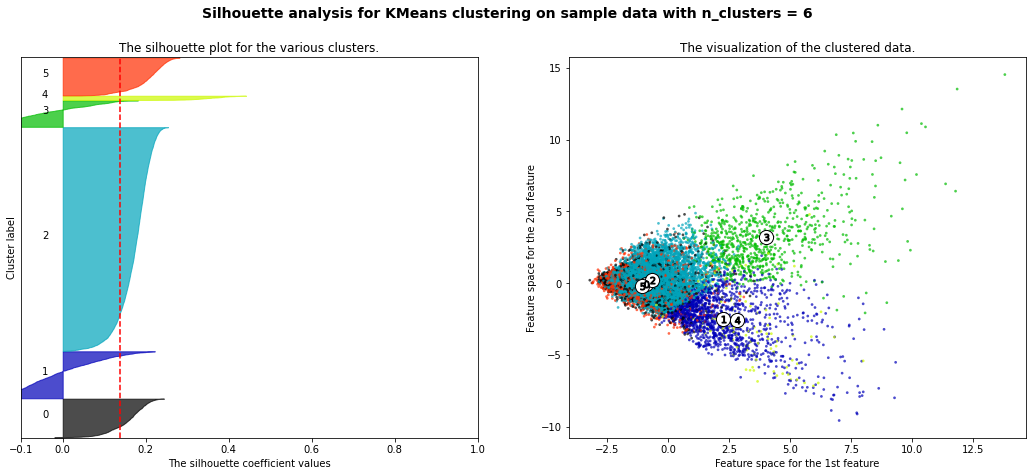

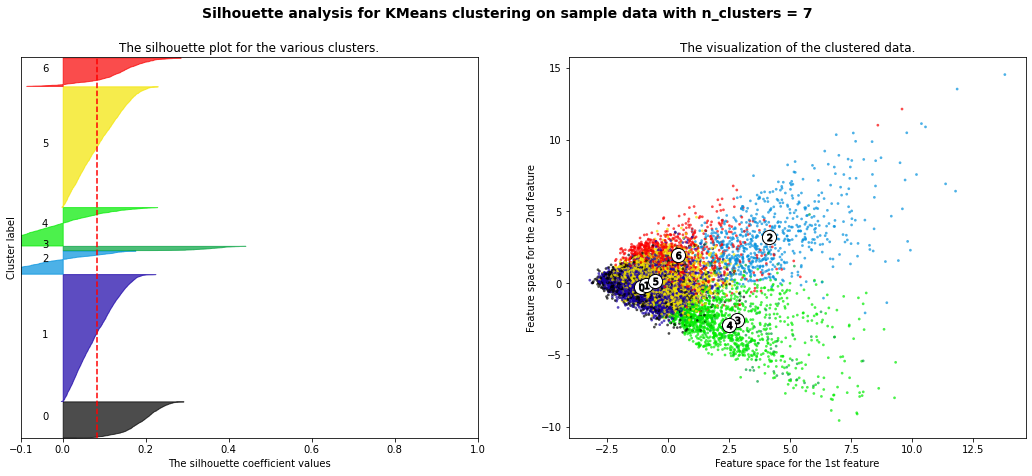

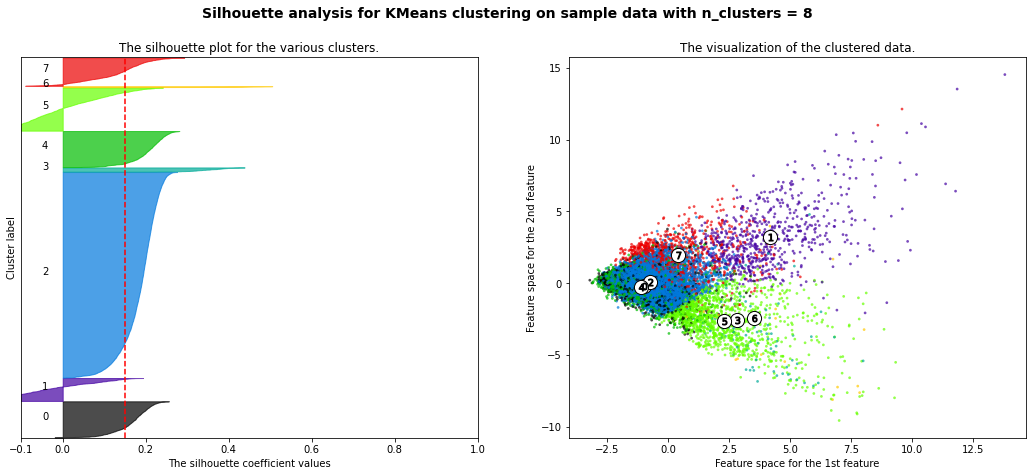

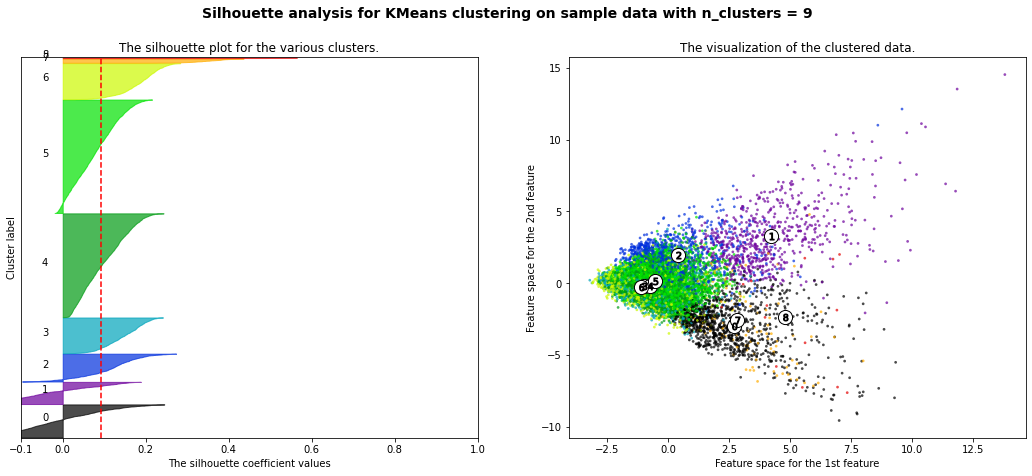

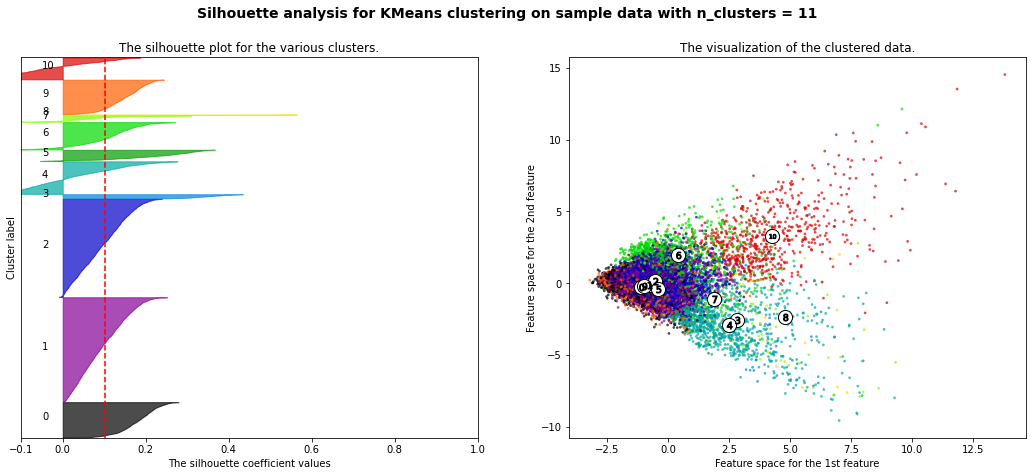

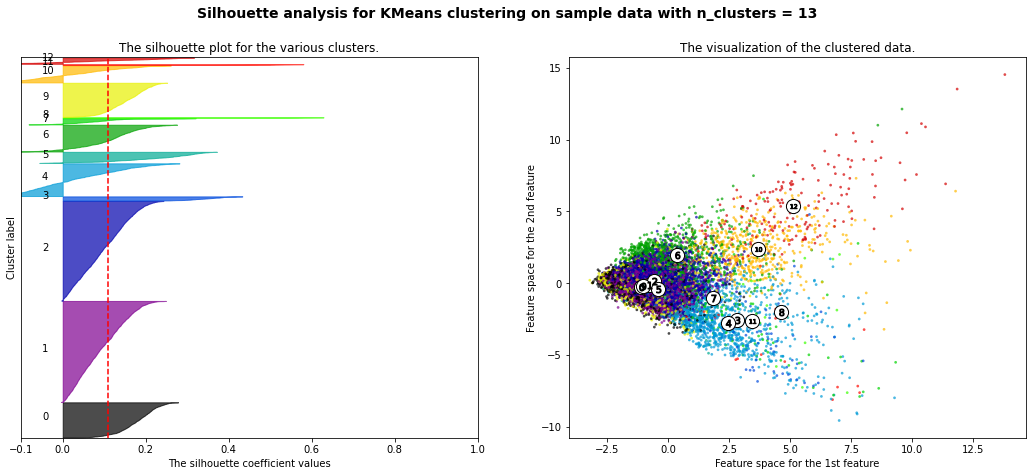

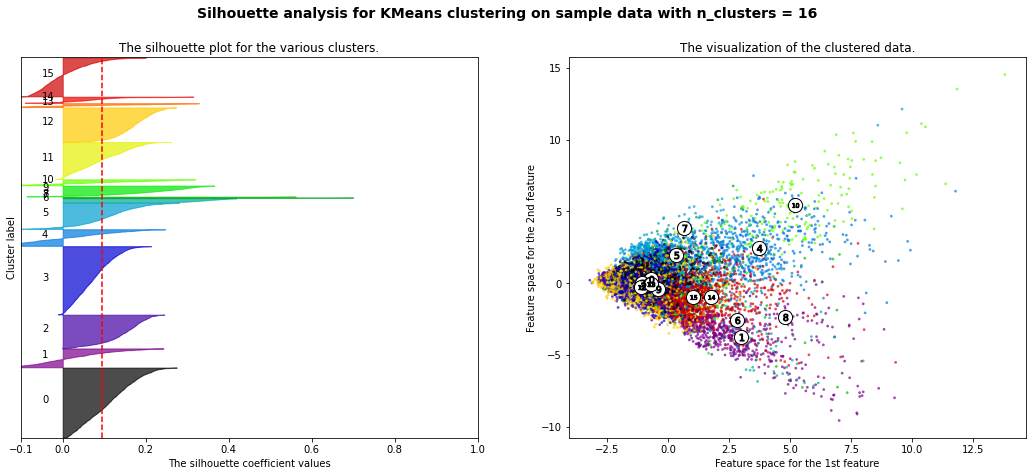

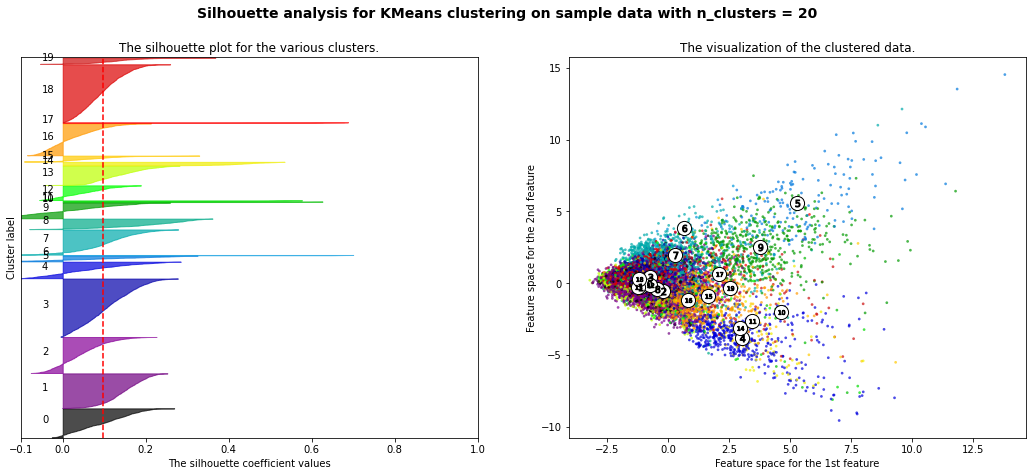

In [28]:
k = 2
kmeans = KMeans(n_clusters=k)
y_pred = kmeans.fit_predict(X_r)

range_n_clusters = [2, 3, 4] + kmeans_chosen

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_r) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_r)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_r, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_r, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_r[:, 0], X_r[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

Now, we are going to look more closely at these cases. In particular, we are going to increase n_init from the default 10 to 15.

At the end of the day, we would like to be able to infer things in relation to the dataset features, not PCA. So, we need a function that does this:

In [24]:
feature_to_pca = sample[3].components_
feature_to_pca.shape

(25, 43)

In [25]:
def pca_coef_to_feature(L, feature_to_pca):
    """Takes a list of arrays in PC basis and the PC coordinates in feature basis.
    Returns the list of arrays in feature basis."""
    
    back_to_feature = []
    
    for a in L:
        back_to_feature_a = []
        for j in range(feature_to_pca.shape[1]):
            coef_j = 0
            for i in range(a.shape[0]):
                coef_j += a[i] * feature_to_pca[i, j]
            back_to_feature_a.append(coef_j)
        back_to_feature.append(back_to_feature_a)
    return np.array(back_to_feature)

In [29]:
kmeans_ch_chosen, kmeans_db_chosen, kmeans_s_chosen = [], [], []
kmeans_info = pd.DataFrame(index=DE.index)
centroid = pd.DataFrame(columns=DE.columns)

for k in kmeans_chosen:
    kmeans = KMeans(n_clusters=k, n_init=15)
    y_pred = kmeans.fit_predict(X)
    
    kmeans_info['cluster_kmeans_%d' %k] = pd.Series(y_pred)
    
    centroid_k = pd.DataFrame(pca_coef_to_feature(kmeans.cluster_centers_, feature_to_pca),
                              index={'%d th centroid_kmenas_%d' %(i, k)  for i in range(k)},
                             columns=DE.columns)
    centroid = centroid.append(centroid_k)

    kmeans_db_chosen.append((k, davies_bouldin_score(X, y_pred)))
    kmeans_ch_chosen.append((k, metrics.calinski_harabasz_score(X, y_pred)))
    kmeans_s_chosen.append((k, silhouette_score(X, y_pred, sample_size=sample_size)))

    distance = []
    for i in range(y_pred.shape[0]):
        d_i = np.sum(np.square(X[i] - kmeans.cluster_centers_[y_pred[i]]))
        distance.append(d_i)

    kmeans_info['distance_to_centroid_kmeans_%d' %k] = pd.Series(np.array(distance))
kmeans_info.to_csv('best_kmeans_info.csv')
centroid.to_csv('best_kmeans_centroid.csv')

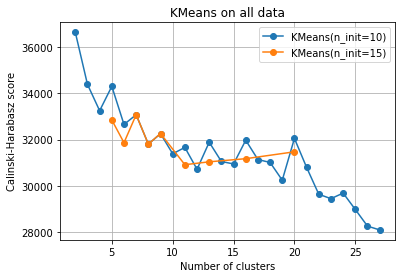

In [30]:
plt.plot([x[0] for x in kmeans_ch_score], [x[1] for x in kmeans_ch_score] , marker = 'o', label='KMeans(n_init=10)')
plt.plot([x[0] for x in kmeans_ch_chosen], [x[1] for x in kmeans_ch_chosen] , marker = 'o', label='KMeans(n_init=15)')
plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabasz score')
plt.title('KMeans on all data')
plt.grid()
plt.legend()
plt.savefig('CH-score-KMeans_2.png')
plt.show()

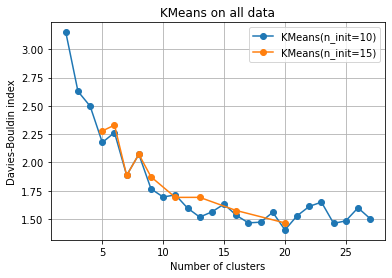

In [31]:
plt.plot([x[0] for x in kmeans_db_score], [x[1] for x in kmeans_db_score] , marker = 'o', label='KMeans(n_init=10)')
plt.plot([x[0] for x in kmeans_db_chosen], [x[1] for x in kmeans_db_chosen] , marker = 'o', label='KMeans(n_init=15)')
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin index')
plt.title('KMeans on all data')
plt.grid()
plt.legend()
plt.savefig('DB-index-KMeans_2.png')
plt.show()

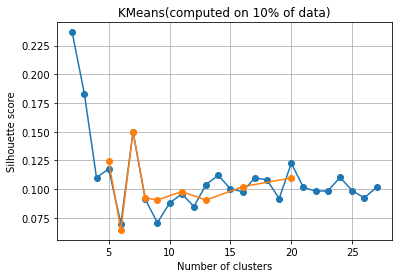

In [32]:
plt.plot([x[0] for x in kmeans_s_score], [x[1] for x in kmeans_s_score] , marker = 'o', label='KMeans(n_init=10)')
plt.plot([x[0] for x in kmeans_s_chosen], [x[1] for x in kmeans_s_chosen] , marker = 'o', label='KMeans(n_init=15)')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('KMeans(computed on 10% of data)')
plt.grid()
plt.savefig('silh-index-KMeans_2.png', dpi=150)
plt.show()

# Using Bayesian Gaussian Mixture Models for finding appropriate k

In [13]:
from sklearn.mixture import BayesianGaussianMixture

In [15]:
for k in range(1, 11):
    bgm = BayesianGaussianMixture(n_components=k)
    bgm.fit(X_r)
    print(np.round(bgm.weights_, 2))

[1.]
[0.89 0.11]
[0.89 0.02 0.09]
[0.17 0.02 0.73 0.08]
[0.01 0.08 0.16 0.7  0.05]
[0.01 0.8  0.06 0.01 0.12 0.  ]
[0.73 0.06 0.05 0.03 0.06 0.05 0.02]
[0.03 0.07 0.65 0.   0.04 0.   0.02 0.2 ]
[0.04 0.06 0.   0.   0.05 0.66 0.01 0.03 0.14]
[0.1  0.02 0.05 0.06 0.   0.5  0.   0.   0.26 0.  ]


I observe that for $k>7$ I always get a component of weight < 0.02, so I'm going with $k=7$ or $k=8$.

In [ ]:
from sklearn.metrics import pairwise_distances

In [ ]:
bgm_8= BayesianGaussianMixture(n_components=8, n_init=10)
bgm_8.fit(X)
print(np.round(bgm_8.weights_, 2))

y_pred_8 = bgm_8.predict(X)

print('Davies-Bouldin score for BGM with 8 comonent is', davies_bouldin_score(X, y_pred_8))

It is much worse than the Davies-Bouldin score for KMeans.

In [ ]:
bgm_7 = BayesianGaussianMixture(n_components=7, n_init=10)
bgm_7.fit(X)
print(np.round(bgm_7.weights_, 2))

y_pred_7 = bgm_7.predict(X)
print('Davies-Bouldin score for BGM with 8 comonent is', davies_bouldin_score(X, y_pred_7))

This one is also much worse than Davies-Bouldin score for KMeans, so this is not a good model for this problem.

# DBSCAN

I think min_samples= 5 is reasonable. Let's see what is the distance to fourth closest neighbor for each instance:

In [33]:
nbrs = NearestNeighbors(n_neighbors=5).fit(X_r)
distances, indices = nbrs.kneighbors(X_r)

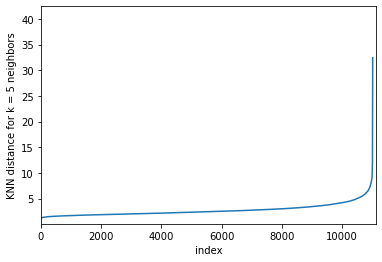

In [34]:
distance_4 = np.sort(distances[:,-1])
index = np.arange(len(distance_4))
plt.plot(index,distance_4)
plt.axis([0, X_r.shape[0] + 100, min(distance_4) - 1, max(distance_4) + 10])
plt.ylabel('KNN distance for k = 5 neighbors')
plt.xlabel('index')
plt.show()

So, we only get higher score when the big majority of data gets sucked into one cluster.

We can also see that here pictorially:

In [40]:
X_r3 = get_sample(DE, 0.03)[0]

For eps = 6 The average silhouette_score is : 0.3185725787688842
For eps = 7 The average silhouette_score is : 0.525384067616628
For eps = 8 The average silhouette_score is : 0.639682492853298
For eps = 9 The average silhouette_score is : 0.6413333419830992
For eps = 10 The average silhouette_score is : 0.6417161153185185


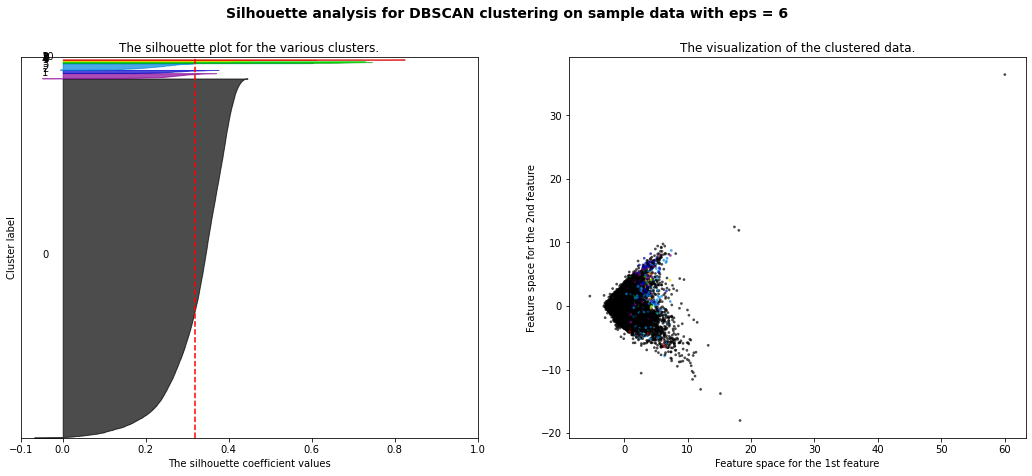

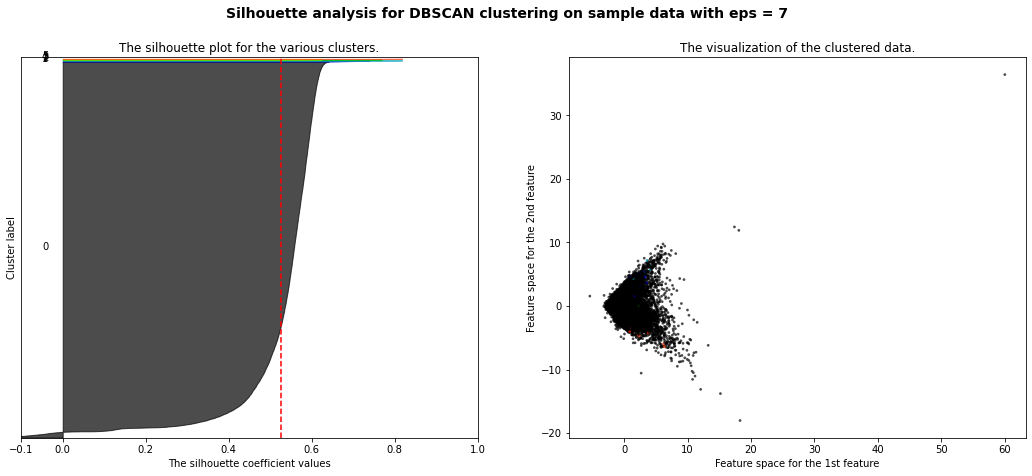

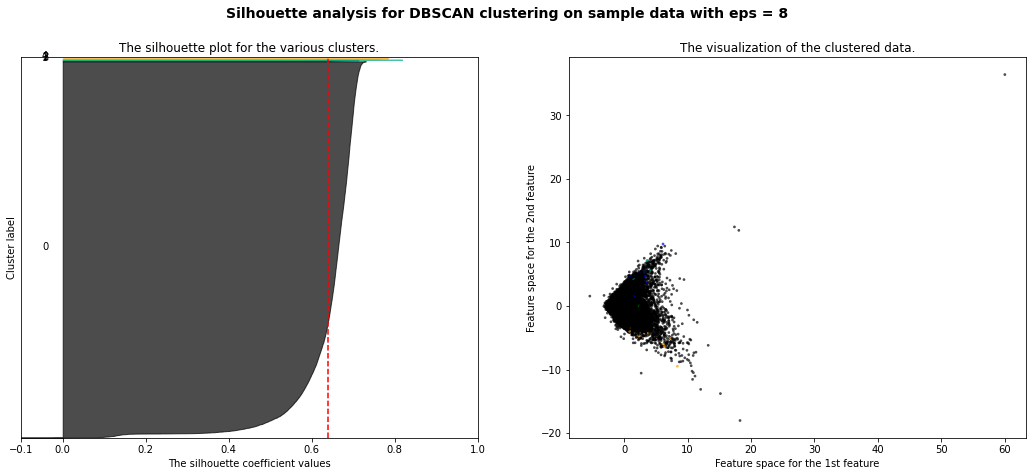

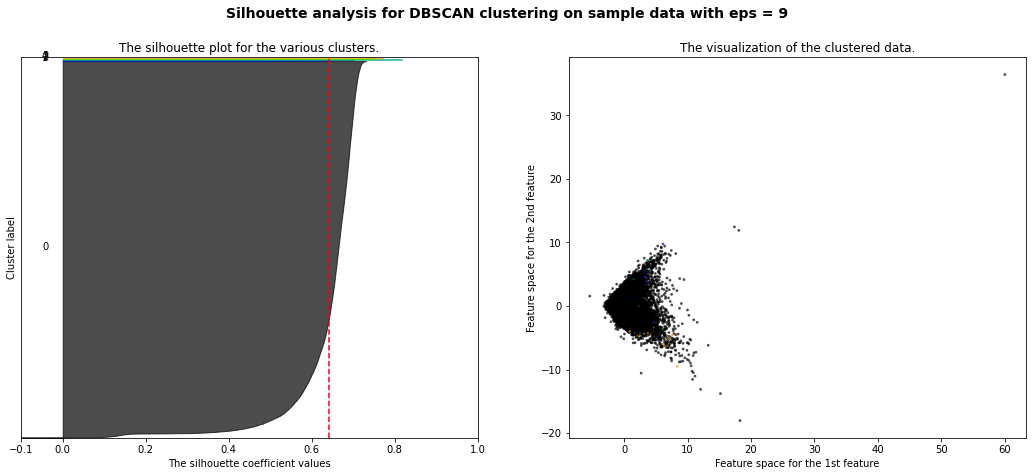

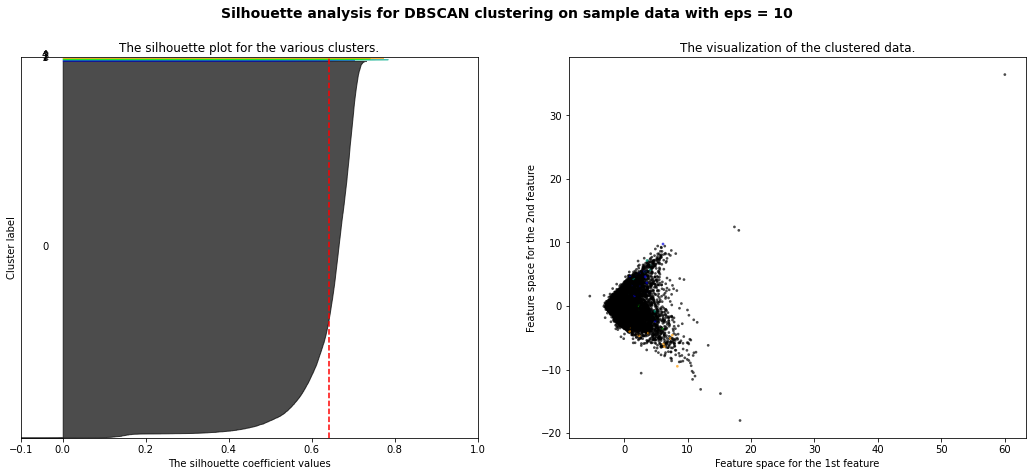

In [41]:
range_eps = [6, 7, 8, 9, 10]

for eps in range_eps:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_r3) + (6) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = DBSCAN(eps=eps, min_samples=5)
    cluster_labels = clusterer.fit(X_r3).labels_
    n_clusters = len(set(cluster_labels)) - (1 if -1 in labels else 0)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_r3, cluster_labels)
    print("For eps =", eps,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_r3, cluster_labels)
    

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_r3[:, 0], X_r3[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    #centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    #ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                #c="white", alpha=1, s=200, edgecolor='k')

    #for i, c in enumerate(centers):
        #ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    #s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for DBSCAN clustering on sample data "
                  "with eps = %d" % eps),
                 fontsize=14, fontweight='bold')
    plt.savefig('Silhouette.png')


plt.show()

With DBSCAN, we get good silhouette scores only when almost all data is in one giant cluster. So, DBSCAN is not a good clustering method for this problem.

# OPTICS

In [16]:
score = []
for k in [5, 10, 11, 12, 13, 14, 15]:
    opt = OPTICS(min_samples=k)
    y_pred = opt.fit_predict(X_r)
    s = silhouette_score(X_r, y_pred)
    score.append(s)
    print ("For min_samples =", k, "OPTICS gives", len(np.unique(y_pred)), "clusters, and the silhouette score is", np.round(s, 2))
    if s > 0.2:
        for x in np.unique(y_pred):
            print("The percent of cluster", x, 'is', np.round(100*len(y_pred[y_pred == x])/len(X_r), 2))

For min_samples = 5 OPTICS gives 97 clusters, and the silhouette score is -0.42
For min_samples = 10 OPTICS gives 10 clusters, and the silhouette score is -0.08
For min_samples = 11 OPTICS gives 10 clusters, and the silhouette score is 0.08
For min_samples = 12 OPTICS gives 7 clusters, and the silhouette score is 0.4
The percent of cluster -1 is 98.87
The percent of cluster 0 is 0.11
The percent of cluster 1 is 0.43
The percent of cluster 2 is 0.11
The percent of cluster 3 is 0.17
The percent of cluster 4 is 0.18
The percent of cluster 5 is 0.14
For min_samples = 13 OPTICS gives 6 clusters, and the silhouette score is 0.08
For min_samples = 14 OPTICS gives 7 clusters, and the silhouette score is -0.09
For min_samples = 15 OPTICS gives 6 clusters, and the silhouette score is -0.06


Again, the same story that happened with DBSCAN, we only get good silhouette score when almost all the data is in one cluster

## Conclusion 

From the clustering methods considered, including Kmeans, DBSCAN, OPTICS, the Kmeans method was most promising. So, we are going to choose Kmeans to be applied to the data. This is done in 'Arrival-delay-Final Analysis.ipynb'